This is the code that goes with the K-means clustering series:

- Part 1
- Part 2
- Part 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from matplotlib import gridspec
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition.pca import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

### Contents

- Initialization Functions
- Post-Initialization Functions
- Blob Data
- Digits Data
- Iris Data

### Initialization Functions

The random partition method randomly assigns each data point to a cluster.

In [2]:
def initialize_clusters(dataframe, number_of_clusters):
    '''
    Initialize the cluster labels using the random partition method which
    randomly assigns each data point to a cluster.
    
    Parameters
    ----------
    dataframe : pandas DataFrame 
        numerical data which is going to be clustered
        
    number_of_clusters : int 
        the number of centroids to initialize (i.e. the desired number of clusters)
        
    Returns
    -------
    cluster_labels : numpy array
        an array of cluster labels
    '''
    # Randomly assign cluster labels
    cluster_labels = np.random.choice(range(number_of_clusters), size = len(dataframe))
    
    # Check whether the number of resulting clusters matches the desired number
    actual_cluster_count = len(set(cluster_labels))
    if (actual_cluster_count < number_of_clusters):
        warning_msg = ('Random initialization yielded {} clusters instead of the desired {}.'
                       .format(actual_cluster_count, number_of_clusters))
        warnings.warn(warning_msg)
        
    return cluster_labels

Forgy initialization picks $K$ points, uniformly at random, to be the initial centroids.

In [3]:
def initialize_centroids_forgy(dataframe, number_of_clusters):
    '''
    Initialize the cluster centroids using the Forgy initialization method of  
    choosing data points uniformly at random.
    
    Parameters
    ----------
    dataframe : pandas DataFrame 
        numerical data which is going to be clustered
        
    number_of_clusters : int 
        the number of centroids to initialize (i.e. the desired number of clusters)
        
    Returns
    -------
    centroids : pandas DataFrame
        a dataframe consisting of the points chosen to be the centroids
    '''
    # Randomly sample centroids from the data
    indices = np.random.choice(dataframe.index, size = number_of_clusters, replace = False)
    
    # Build dataframe of centroids
    centroids = dataframe.loc[indices, :]
    centroids.index = range(number_of_clusters)
    
    return centroids

$K$-means++ successively chooses data points to be initial centroids, where the probability that a point will be chosen as a centroid is proportional to the square of its distance to the nearest existing centroid.

In [4]:
def initialize_centroids_plusplus_with_densities(dataframe, number_of_clusters):
    '''
    Initialize the cluster centroids using the K-Means++ initialization method
    
    Parameters
    ----------
    dataframe : pandas DataFrame 
        numerical data which is going to be clustered
        
    number_of_clusters : int 
        the number of centroids to initialize (i.e. the desired number of clusters)
        
    Returns
    -------
    (centroids, densities) : (pandas DataFrame, dict)
        a dataframe consisting of the points chosen to be the centroids
    '''
    data_points = len(dataframe)
    indices = []
    densities = {}
    
    # Initialize inverted distances to max
    distances = np.array([np.infty for i in range(data_points)])
    # Start with uniform distribution across data
    prob_distribution = np.array([1/data_points for i in range(data_points)])
    
    for i in range(number_of_clusters):
        densities[i] = prob_distribution
        index = int(np.random.choice(range(data_points), size = 1, p = prob_distribution))
        indices.append(index)
        centroid = dataframe.iloc[index]
        
        # Compute inverted distances to centroid
        new_distances = ((dataframe - centroid)
                         .apply(lambda x: x**2)
                         .sum(axis = 1))
        distances = np.minimum(distances, new_distances)
        prob_distribution = (distances/sum(distances)).values

    # Build dataframe of centroids
    centroids = dataframe.loc[indices, :]
    centroids.index = range(number_of_clusters)

    return (centroids, densities)

def initialize_centroids_plusplus(dataframe, number_of_clusters):
    '''
    Initialize the cluster centroids using the K-Means++ initialization method
    
    Parameters
    ----------
    dataframe : pandas DataFrame 
        numerical data which is going to be clustered
        
    number_of_clusters : int 
        the number of centroids to initialize (i.e. the desired number of clusters)
        
    Returns
    -------
    centroids : pandas DataFrame
        a dataframe consisting of the points chosen to be the centroids
    '''
    return initialize_centroids_plusplus_with_densities(dataframe, number_of_clusters)[0]

### Post-Initialization Functions

In [5]:
def compute_centroid(data, clusters):
    df = data.copy()
    df['cluster'] = clusters
    return df.groupby('cluster').mean()

In [6]:
def single_row_cluster_assignment(row, centroids):
    cluster = ((row - centroids)
                   .apply(lambda x: x**2)
                   .sum(axis = 1)
                   .argmin())
    return cluster

def get_cluster_assignments(dataframe, centroids):
    return dataframe.apply(single_row_cluster_assignment, centroids = centroids, axis = 1)

In [7]:
def compute_objective(data, centroids, assignments):
    objective = 0
    for i in centroids.index.values:
        objective += ((data[assignments == i] - centroids.loc[i])
                          .apply(lambda x: x**2)
                          .values.sum())
    return objective

### Blob Data

In [8]:
# Build toy data sets with 4 clusters each, and different variances
X1, y1 = datasets.make_blobs(n_samples = 200, n_features = 2, centers = 4, cluster_std = 0.5, random_state = 0)
X2, y2 = datasets.make_blobs(n_samples = 200, n_features = 2, centers = 4, cluster_std = 0.75, random_state = 0)
X3, y3 = datasets.make_blobs(n_samples = 200, n_features = 2, centers = 4, cluster_std = 1.0, random_state = 0)

X1_df = pd.DataFrame(X1, columns = ['x', 'y'])
X2_df = pd.DataFrame(X2, columns = ['x', 'y'])
X3_df = pd.DataFrame(X3, columns = ['x', 'y'])
X1_df.head()

,x,y
0,2.204387,1.560857
1,-1.133740,2.684673
2,1.064983,4.102897
3,-2.376038,7.324207
4,1.682890,0.484444


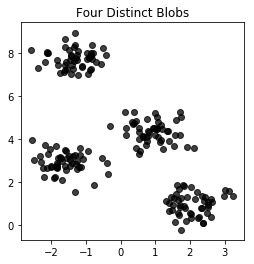

In [9]:
fig = plt.figure(figsize = [4, 4])
plt.scatter(X1[:, 0], X1[:, 1], c = 'black', alpha = 0.75)
plt.title('Four Distinct Blobs')
# plt.savefig('four_blobs.png', bbox_inches='tight')
plt.show()

### Digits Data

In [10]:
digits = datasets.load_digits()
digits_data = digits.data
digits_data.shape

(1797, 64)

In [11]:
digits_data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

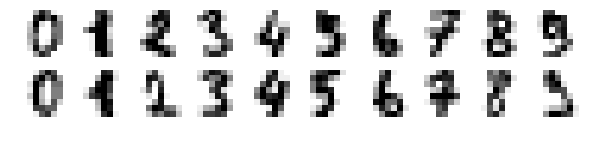

In [13]:
plt.figure(figsize = [10, 2])
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.axis('off')
    plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
# plt.savefig('example_digits.png', bbox_inches='tight')
plt.show()

In [14]:
digit_kmeans = KMeans(n_clusters = 3, random_state = 0).fit(digits_data)
digit_labels = digit_kmeans.labels_

np.random.seed(0)
samples = 16
class_1 = np.random.choice(np.where(digit_labels == 0)[0], size = samples, replace = False)
class_2 = np.random.choice(np.where(digit_labels == 1)[0], size = samples, replace = False)
class_3 = np.random.choice(np.where(digit_labels == 2)[0], size = samples, replace = False)

In [15]:
blah = pd.DataFrame({'cluster':digit_labels, 'digit':digits.target})
pd.crosstab(blah.cluster, blah.digit)

digit,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,2,38,161,167,0,72,1,0,65,146
1,0,140,16,16,55,97,1,179,108,34
2,176,4,0,0,126,13,179,0,1,0


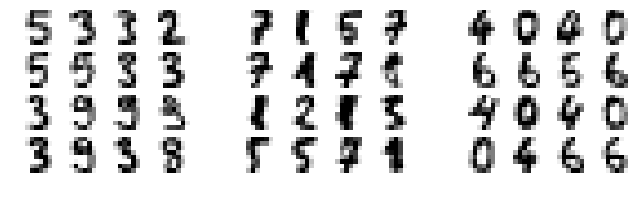

In [16]:
plt.figure(figsize = [11, 3])
for i in range(min(16, len(class_1))):
    plt.subplot(4, 14, 1 + (i//4)*14 + i%4)
    plt.axis('off')
    plt.imshow(digits.images[class_1[i]], cmap=plt.cm.gray_r, interpolation='nearest')
    
for i in range(min(16, len(class_2))):
    plt.subplot(4, 14, 6 + (i//4)*14 + i%4)
    plt.axis('off')
    plt.imshow(digits.images[class_2[i]], cmap=plt.cm.gray_r, interpolation='nearest')
    
for i in range(min(16, len(class_3))):
    plt.subplot(4, 14, 11 + (i//4)*14 + i%4)
    plt.axis('off')
    plt.imshow(digits.images[class_3[i]], cmap=plt.cm.gray_r, interpolation='nearest')

# plt.savefig('digit_clusters.png', bbox_inches='tight')
plt.show()

In [17]:
digit_pca = PCA(n_components = 2).fit_transform(digits_data)

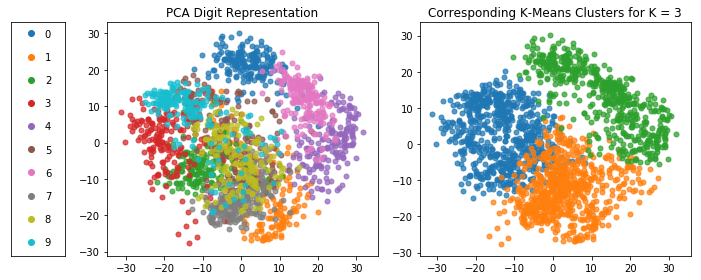

In [18]:
fig = plt.figure(figsize=(10, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 5, 5]) 
ax0 = plt.subplot(gs[0])
ax0.tick_params(axis = 'both', which = 'both', 
                bottom = 'off', top = 'off', left = 'off', right = 'off',
                labelbottom = 'off', labelleft = 'off')

for i in range(10):
    ax0.scatter([0], [10 - i])
    ax0.scatter([0.5], [10 - i], alpha = 0, c = 'white')
    ax0.scatter([-0.5], [10 - i], alpha = 0, c = 'white')
    ax0.scatter([1.0], [10 - i], alpha = 0, c = 'white')
    ax0.text(0.5, 10 - i - 0.15, i)

ax1 = plt.subplot(gs[1])
plt.title('PCA Digit Representation')
for i in range(10):
    points = digit_pca[digits.target == i]
    ax1.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 25)
    
ax2 = plt.subplot(gs[2])
plt.title('Corresponding K-Means Clusters for K = 3')
for i in range(3):
    points = digit_pca[digit_labels == i]
    ax2.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 25)

plt.tight_layout()
# plt.savefig('digits_pca.png', bbox_inches='tight')
plt.show()

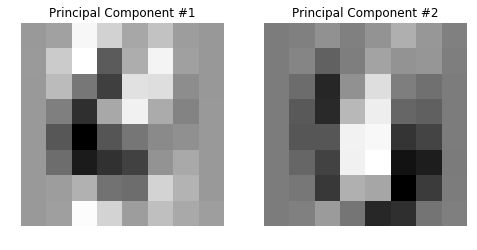

In [19]:
n_pca_components = 2
pca_components = PCA(n_components = n_pca_components).fit(digits_data)

fig = plt.figure(figsize = [4*n_pca_components, 4])

for i in range(n_pca_components):
    plt.subplot(1, n_pca_components, 1 + i)
    plt.title('Principal Component #{}'.format(1 + i))
    plt.axis('off')
    plt.imshow(pca_components.components_[i].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [20]:
# Compute T-SNE representation of digits (this can take some time)
digit_tsne = TSNE(random_state = 0).fit_transform(digits_data)

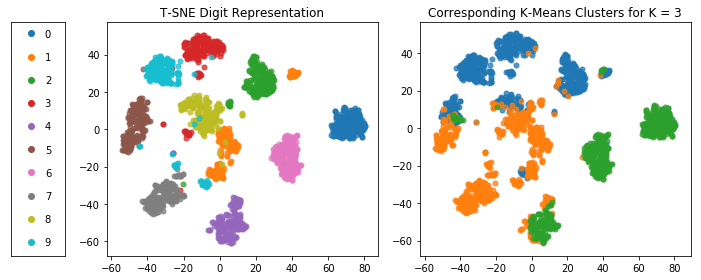

In [21]:
fig = plt.figure(figsize=(10, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 5, 5]) 
ax0 = plt.subplot(gs[0])
ax0.tick_params(axis = 'both', which = 'both', 
                bottom = 'off', top = 'off', left = 'off', right = 'off',
                labelbottom = 'off', labelleft = 'off')

for i in range(10):
    ax0.scatter([0], [10 - i])
    ax0.scatter([0.5], [10 - i], alpha = 0, c = 'white')
    ax0.scatter([-0.5], [10 - i], alpha = 0, c = 'white')
    ax0.scatter([1.0], [10 - i], alpha = 0, c = 'white')
    ax0.text(0.5, 10 - i - 0.15, i)

ax1 = plt.subplot(gs[1])
plt.title('T-SNE Digit Representation')
for i in range(10):
    points = digit_tsne[digits.target == i]
    ax1.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 25)
    
ax2 = plt.subplot(gs[2])
plt.title('Corresponding K-Means Clusters for K = 3')
for i in range(3):
    points = digit_tsne[digit_labels == i]
    ax2.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 25)

plt.tight_layout()
# plt.savefig('digits_tsne.png', bbox_inches='tight')
plt.show()

### Iris Data

In [22]:
iris = datasets.load_iris()
iris_data = pd.DataFrame(iris.data, columns = iris.feature_names)

iris_data_full = iris_data.copy()
iris_data_full['species'] = iris.target_names[iris.target]

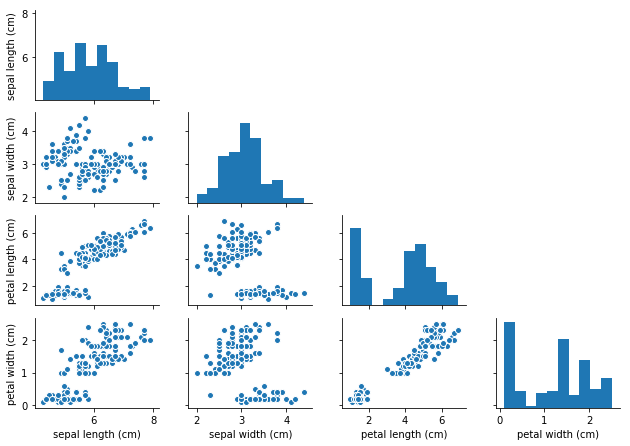

In [23]:
g = sns.pairplot(iris_data_full)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

g.fig.set_size_inches([9, 6])
# g.savefig('iris_pairplot_unlabeled.png', bbox_inches='tight')

plt.show()

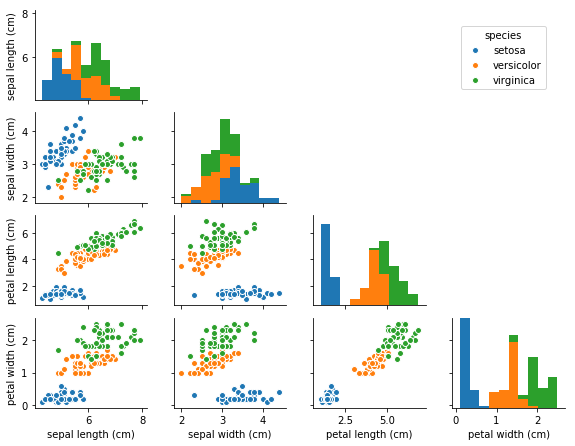

In [24]:
g = sns.pairplot(iris_data_full, hue = 'species')
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

g.fig.set_size_inches([9, 6], )
leg = g.fig.get_children()[-1]
leg.set_bbox_to_anchor((0.85, 0.9, 0, 0))
#leg.set_frame_on(False)

# g.savefig('iris_pairplot_labeled.png', bbox_inches='tight')

plt.show()

In [ ]:
# Represent data using first 2 principal components
iris_pca = PCA(n_components = 2).fit_transform(iris_data)

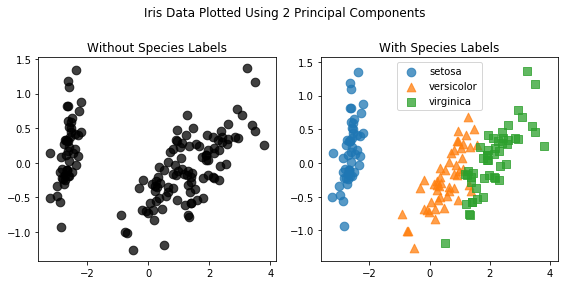

In [25]:
fig = plt.figure(figsize = [8,4])
fig.suptitle("Iris Data Plotted Using 2 Principal Components")

# Plot unlabeled irises
plt.subplot(1, 2, 1)
plt.title('\n\nWithout Species Labels')
plt.scatter(iris_pca[:, 0], iris_pca[:, 1], color = 'black', alpha = 0.75, s = 75)

# Label the different species
plt.subplot(1, 2, 2)
plt.title('\n\nWith Species Labels')
marker_list = ['o', '^', 's']
for index, species in enumerate(iris.target_names):
    points = iris_pca[iris.target == index]
    plt.scatter(points[:, 0], points[:, 1], label = species, marker = marker_list[index], alpha = 0.75, s = 75)

plt.legend(loc = 9)
plt.tight_layout()

# plt.savefig('iris_PCA.png', bbox_inches='tight')
plt.show()

In [ ]:
# Run K-means with K = 2, 3
iris_kmeans_2 = KMeans(n_clusters = 2, random_state = 0).fit(iris_data)
iris_kmeans_3 = KMeans(n_clusters = 3, random_state = 0).fit(iris_data)

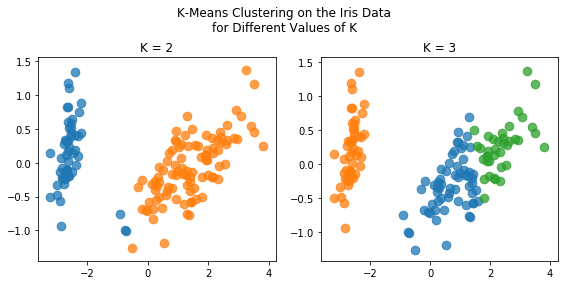

In [26]:
fig = plt.figure(figsize = [8, 4])

plt.subplot(1, 2, 1)
plt.title("\n\nK = 2")
for i in range(2):
    points = iris_pca[iris_kmeans_2.labels_ == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 75)
    
plt.subplot(1, 2, 2)
plt.title("\n\nK = 3")
for i in range(3):
    points = iris_pca[iris_kmeans_3.labels_ == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 75)
    
plt.suptitle('K-Means Clustering on the Iris Data\nfor Different Values of K')
plt.tight_layout()

# plt.savefig('iris_clustering.png', bbox_inches='tight')

plt.show()

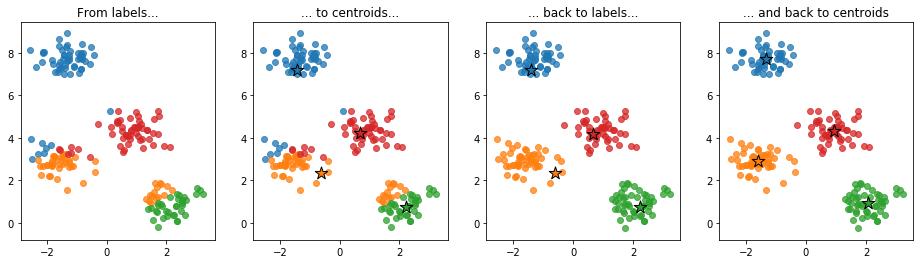

In [27]:
np.random.seed(0)
initial_centroids = initialize_centroids_forgy(X1_df, 4)
initial_assignments = get_cluster_assignments(X1_df, initial_centroids)
new_centroids = compute_centroid(data = X1_df, clusters = initial_assignments)
new_assignments = get_cluster_assignments(X1_df, new_centroids)
newer_centroids = compute_centroid(data = X1_df, clusters = new_assignments)
newer_assignments = get_cluster_assignments(X1_df, newer_centroids)

fig = plt.figure(figsize = [16, 4])

plt.subplot(1, 4, 1)
plt.title('From labels...')

for i in initial_centroids.index.values:
    points = X1[initial_assignments == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75)

plt.subplot(1, 4, 2)
plt.title('... to centroids...')

for i in initial_centroids.index.values:
    points = X1[initial_assignments == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75)

plt.gca().set_prop_cycle(None)

for i in initial_centroids.index.values:
    plt.scatter(new_centroids.loc[i][0], new_centroids.loc[i][1], marker = '*', s = 175, edgecolors = 'black')
    
plt.subplot(1, 4, 3)
plt.title('... back to labels...')

for i in new_assignments.index.values:
    points = X1[new_assignments == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75)

plt.gca().set_prop_cycle(None)

for i in initial_centroids.index.values:
    plt.scatter(new_centroids.loc[i][0], new_centroids.loc[i][1], marker = '*', s = 175, edgecolors = 'black')
    
plt.subplot(1, 4, 4)
plt.title('... and back to centroids')

for i in new_assignments.index.values:
    points = X1[new_assignments == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75)
    
plt.gca().set_prop_cycle(None)

for i in initial_centroids.index.values:
    plt.scatter(newer_centroids.loc[i][0], newer_centroids.loc[i][1], marker = '*', s = 175, edgecolors = 'black')

# plt.savefig('clustering_process.png', bbox_inches='tight')
plt.show()